In [1]:
#https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

In [2]:
import numpy as np
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                        parse_dates=["Date"],
                        index_col=["Date"])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [4]:
bitcoin_prices = pd.DataFrame(df['Closing Price (USD)']).rename(columns={'Closing Price (USD)':'Price'})
bitcoin_prices

,Price
Date,
2013-10-01,123.654990
2013-10-02,125.455000
2013-10-03,108.584830
2013-10-04,118.674660
2013-10-05,121.338660
...,...
2021-05-14,49764.132082
2021-05-15,50032.693137
2021-05-16,47885.625255


Text(0.5, 1.0, 'Price of bitcoin')

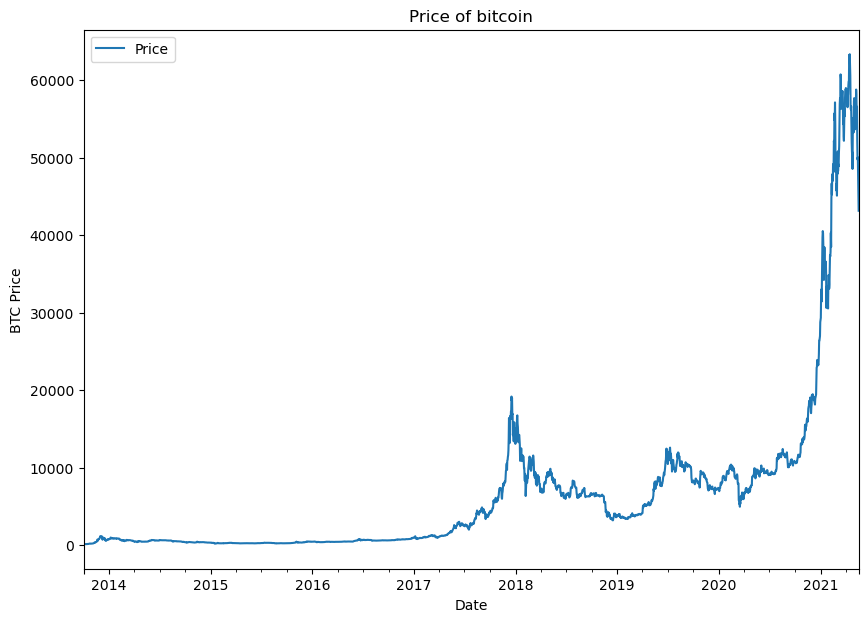

In [5]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10,7))
plt.ylabel("BTC Price")
plt.title("Price of bitcoin")

In [6]:
bitcoin_prices

,Price
Date,
2013-10-01,123.654990
2013-10-02,125.455000
2013-10-03,108.584830
2013-10-04,118.674660
2013-10-05,121.338660
...,...
2021-05-14,49764.132082
2021-05-15,50032.693137
2021-05-16,47885.625255


In [7]:
#011 Reading in our Bitcoin data with Python's CSV module
#012 Creating train and test splits for time series (the wrong way)
#013 Creating train and test splits for time series (the right way)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(bitcoin_prices.index.to_numpy(), bitcoin_prices['Price'].to_numpy(), test_size=0.2,shuffle=False, random_state=42)

In [8]:
# #The other way
# timesteps = bitcoin_prices.index.to_numpy()
# prices = bitcoin_prices["Price"].to_numpy()
# split_size = int(0.8 * len(prices)) # 80% train, 20% test
# X_train, y_train = timesteps[:split_size], prices[:split_size]
# X_test, y_test = timesteps[split_size:], prices[split_size:]
#
# len(X_train), len(X_test), len(y_train), len(y_test)

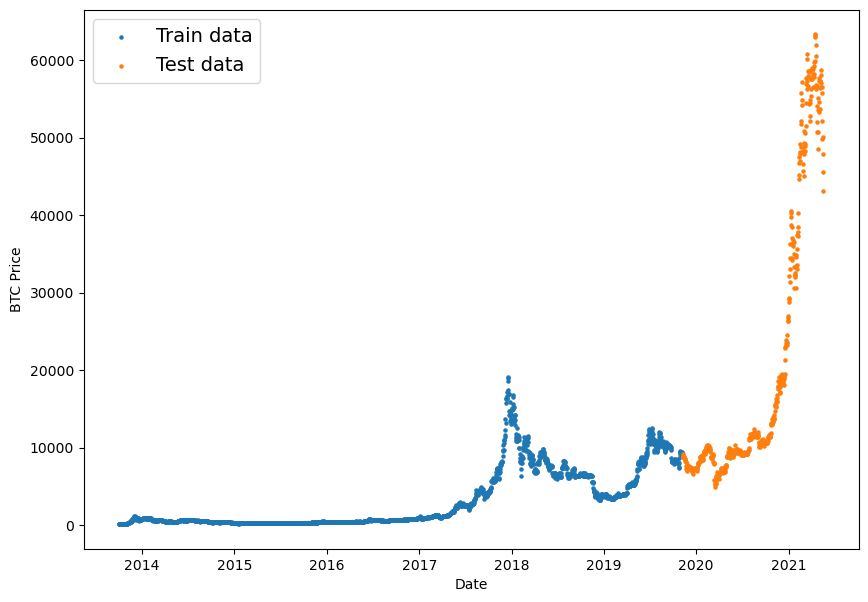

In [9]:
plt.figure(figsize=(10,7))
plt.scatter(X_train,y_train,s=5,label="Train data")
plt.scatter(X_test,y_test,s=5,label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show()

In [10]:
#014 Creating a plotting function to visualize our time series data
def plot_time_series(timesteps,values,format=".",start=0,end = None,label=None):
    plt.plot(timesteps[start:end],values[start:end],format,label=label)
    plt.xlabel("Time")
    plt.ylabel("BTC Price")
    if label:
        plt.legend(fontsize = 14)
    plt.grid(True)


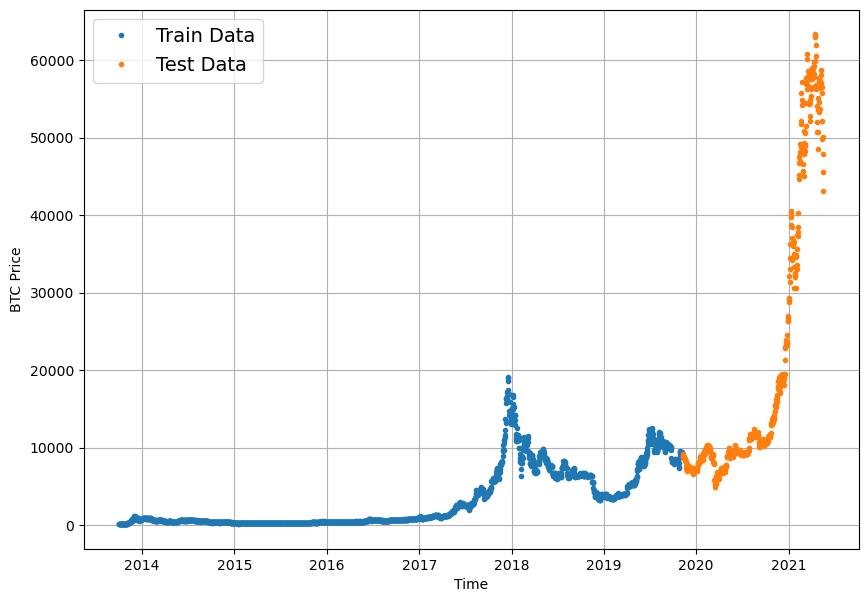

In [11]:
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train,values=y_train,label="Train Data")
plot_time_series(timesteps=X_test,values=y_test,label="Test Data")

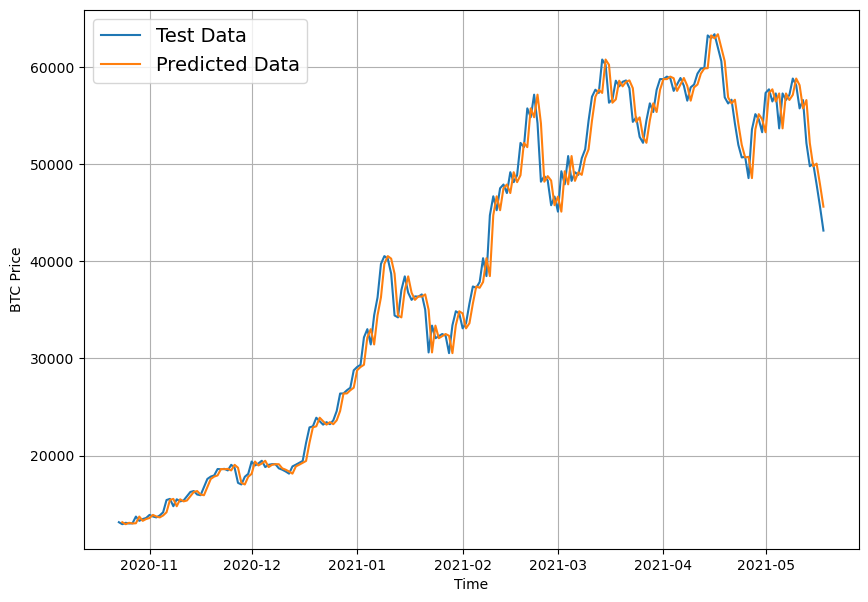

In [12]:
#015 Discussing the various modelling experiments were going to be running
#016 Model 0 Making and visualizing a naive forecast model
# naive forecast at time t is the value at (t-1)
naive_forecast = y_test[:-1]
plt.figure(figsize=(10,7))
#plot_time_series(timesteps=X_train,values=y_train,label="Train Data")
plot_time_series(timesteps=X_test,values=y_test,start=350,format="-",label="Test Data")
plot_time_series(timesteps=X_test[1:],values=naive_forecast,start=350,format="-",label="Predicted Data")


In [13]:
#017 Discussing some of the most common time series evaluation metrics
#018 Implementing MASE with TensorFlow
import tensorflow as tf
def mean_absolute_scaled_error(y_true,y_pred):

    mae = tf.reduce_mean(tf.abs(y_true-y_pred))
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:]-y_true[:-1]))
    return mae / mae_naive_no_season

In [14]:
mean_absolute_scaled_error(y_true=y_test[1:],y_pred=naive_forecast).numpy()

0.9995699939182624

In [15]:
#019 Creating a function to evaluate our model's forecasts with various metrics
def evaluate_preds(y_true,y_pred):
    y_true = tf.cast(y_true,dtype=tf.float32)
    y_pred = tf.cast(y_pred,dtype=tf.float32)

    mae = tf.keras.metrics.mean_absolute_error(y_true,y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true,y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true,y_pred)
    mase = mean_absolute_scaled_error(y_true,y_pred)

    return {"mae":mae.numpy(),
            "mse":mse.numpy(),
            "rmse":rmse.numpy(),
            "mape":mape.numpy(),
            "mase":mase.numpy()}

In [16]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

In [17]:
#020 Discussing other non-TensorFlow kinds of time series forecasting models
#021 Formatting data Part 2 Creating a function to label our windowed time series
bitcoin_prices['Price'].to_numpy()[:7]

array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])

In [18]:
HORIZON = 1
WINDOW_SIZE = 7

def get_labelled_window(x,horizon=HORIZON):
    return x[:,:-horizon],x[:,-horizon:]

In [19]:
#022 Discussing the use of windows and horizons in time series data
#023 Writing a preprocessing function to turn time series data into windows & labels
import numpy as np
def make_windows(x,window_size=WINDOW_SIZE,horizon=HORIZON):
    window_step=np.expand_dims(np.arange(window_size+horizon),axis=0)
    window_indexes = window_step +np.expand_dims(np.arange(len(x)-(window_size+horizon-1)),axis=0).T
    windowed_array = x[window_indexes]
    windows,labels = get_labelled_window(windowed_array,horizon=horizon)
    return windows,labels

In [20]:
full_windows,full_labels = make_windows(bitcoin_prices['Price'].to_numpy(),window_size=WINDOW_SIZE,horizon=HORIZON)

In [21]:
full_windows

array([[  123.65499   ,   125.455     ,   108.58483   , ...,
          121.33866   ,   120.65533   ,   121.795     ],
       [  125.455     ,   108.58483   ,   118.67466   , ...,
          120.65533   ,   121.795     ,   123.033     ],
       [  108.58483   ,   118.67466   ,   121.33866   , ...,
          121.795     ,   123.033     ,   124.049     ],
       ...,
       [58788.20967893, 58102.19142623, 55715.54665129, ...,
        52147.82118698, 49764.1320816 , 50032.69313676],
       [58102.19142623, 55715.54665129, 56573.5554719 , ...,
        49764.1320816 , 50032.69313676, 47885.62525472],
       [55715.54665129, 56573.5554719 , 52147.82118698, ...,
        50032.69313676, 47885.62525472, 45604.61575361]])

In [22]:
#Insted of above , the below can also be used
# data = [x for x in range(21)]
# input_data = data[:-3]
# targets = data[3:]
# dataset = tf.keras.utils.timeseries_dataset_from_array(
#     input_data, targets, sequence_length=3)
#
# for batch in dataset:
#   inputs, targets = batch
#   print(inputs,targets)

In [23]:
#024 Turning our windowed time series data into training and test sets
def make_train_test_splits(windows,labels,test_split=0.2):
    split_size = int(len(windows)*(1-test_split))
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]

    return train_windows,test_windows,train_labels,test_labels

In [24]:
train_windows,test_windows,train_labels,test_labels = make_train_test_splits(full_windows,full_labels)

In [25]:
#025 Creating a modelling checkpoint callback to save our best performing model
import os

def create_model_checkpoint(model_name,save_path = "model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path,model_name),verbose=0,save_best_only=True,monitor='val_loss',)

In [26]:
#026 Model 1 Building, compiling and fitting a deep learning model on Bitcoin data
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
    layers.Dense(128,activation='relu'),
    layers.Dense(HORIZON,activation = 'linear')
],name="model_1_dense")

model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics = ['mae','mse'])

model_1.fit(x = train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,

            validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])


Epoch 1/100
18/18 [==============================] - 3s 40ms/step - loss: 1699.3719 - mae: 1699.3719 - mse: 8779644.0000 - val_loss: 1162.9877 - val_mae: 1162.9877 - val_mse: 4215849.0000
Epoch 2/100
18/18 [==============================] - 0s 4ms/step - loss: 347.0797 - mae: 347.0797 - mse: 478713.6562 - val_loss: 1610.9364 - val_mae: 1610.9364 - val_mse: 6320801.0000
Epoch 3/100
18/18 [==============================] - 0s 24ms/step - loss: 225.4788 - mae: 225.4788 - mse: 241101.1250 - val_loss: 1058.2959 - val_mae: 1058.2959 - val_mse: 3560501.5000
Epoch 4/100
18/18 [==============================] - 0s 24ms/step - loss: 190.6868 - mae: 190.6868 - mse: 184830.5000 - val_loss: 1023.7849 - val_mae: 1023.7849 - val_mse: 3514599.2500
Epoch 5/100
18/18 [==============================] - 0s 4ms/step - loss: 183.7250 - mae: 183.7250 - mse: 177824.9219 - val_loss: 1024.3652 - val_mae: 1024.3652 - val_mse: 3362832.5000
Epoch 6/100
18/18 [==============================] - 0s 24ms/step - loss: 

In [27]:
model_1.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 11ms/step - loss: 621.4023 - mae: 621.4023 - mse: 1271909.2500


[621.40234375, 621.40234375, 1271909.25]

In [28]:
model_1 = tf.keras.models.load_model('model_experiments/model_1_dense/')
model_1.evaluate(test_windows,test_labels)

18/18 [==============================] - 1s 11ms/step - loss: 567.9968 - mae: 567.9968 - mse: 1170319.0000


[567.996826171875, 567.996826171875, 1170319.0]

In [29]:
#027 Creating a function to make predictions with our trained models
def make_preds(model,input_data):
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)

In [30]:
model_1_preds = make_preds(model_1,test_windows)

18/18 [==============================] - 1s 9ms/step


In [31]:
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),y_pred=model_1_preds)
model_1_results

{'mae': 567.9968,
 'mse': 1170318.9,
 'rmse': 1081.8127,
 'mape': 2.5540593,
 'mase': 0.9978131}

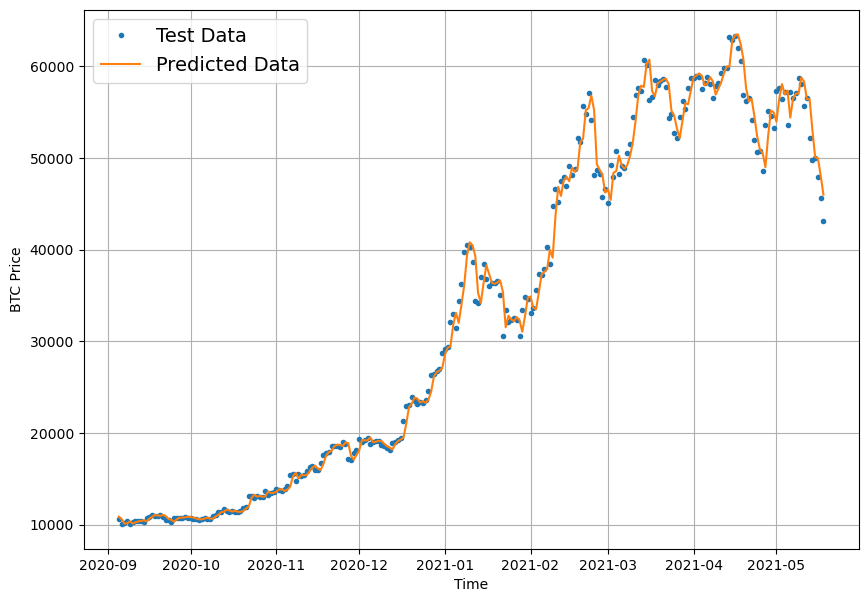

In [32]:
offset = 300
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):],values=test_labels[:,0],start=offset,label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):],values=model_1_preds,start=offset,format="-",label="Predicted Data")

In [33]:
#028 Model 2 Building, fitting and evaluating a deep model with a larger window size
HORIZON = 1
WINDOW_SIZE = 30

full_windows,full_labels = make_windows(bitcoin_prices['Price'].to_numpy(),window_size=WINDOW_SIZE,horizon=HORIZON)
train_windows,test_windows,train_labels,test_labels = make_train_test_splits(full_windows,full_labels)

In [34]:
tf.random.set_seed(42)

model_2 = tf.keras.Sequential([
    layers.Dense(128,activation="relu"),
    layers.Dense(HORIZON)
],name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: mod

In [35]:
model_2.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 698.4860 - mae: 698.4860


[698.4860229492188, 698.4860229492188]

In [36]:
model_2 = tf.keras.models.load_model('model_experiments/model_2_dense/')
model_2.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 560.7030 - mae: 560.7030


[560.7030029296875, 560.7030029296875]

In [37]:
model_2_preds = make_preds(model_2,input_data=test_windows,)
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),y_pred=model_2_preds)
model_2_results

18/18 [==============================] - 0s 2ms/step


{'mae': 560.703,
 'mse': 1148525.9,
 'rmse': 1071.693,
 'mape': 2.5228593,
 'mase': 0.9849999}

In [38]:
model_1_results

{'mae': 567.9968,
 'mse': 1170318.9,
 'rmse': 1081.8127,
 'mape': 2.5540593,
 'mase': 0.9978131}

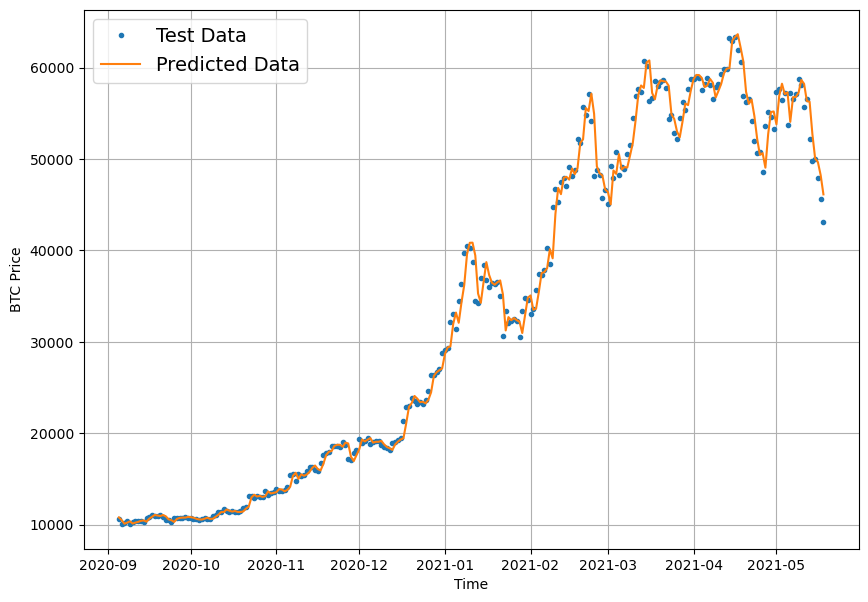

In [39]:
offset = 300
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):],values=test_labels[:,0],start=offset,label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):],values=model_2_preds,start=offset,format="-",label="Predicted Data")

In [40]:
#029 Model 3 Building, fitting and evaluating a model with a larger horizon size
HORIZON = 7
WINDOW_SIZE = 30

full_windows,full_labels = make_windows(bitcoin_prices['Price'].to_numpy(),window_size=WINDOW_SIZE,horizon=HORIZON)
train_windows,test_windows,train_labels,test_labels = make_train_test_splits(full_windows,full_labels)

In [41]:
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
    layers.Dense(128,activation='relu'),
    layers.Dense(HORIZON)
],name= 'model_3_dense')

model_3.compile(loss='MAE',
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: mod

In [42]:
model_3.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 1314.8918


1314.891845703125

In [43]:
model_3 = tf.keras.models.load_model('model_experiments/model_3_dense')
model_3.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 1232.7209


1232.720947265625

In [44]:
model_3_preds = make_preds(model_3,input_data=test_windows)

18/18 [==============================] - 0s 585us/step


In [45]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([  740.86847 ,   384.1141  ,   370.50278 ,   507.43582 ,
          444.26074 ,   556.26514 ,   585.49286 ,   620.66327 ,
          463.1838  ,   471.82938 ,   747.7716  ,   722.90466 ,
          881.4657  ,   916.24176 ,   640.77893 ,   256.71066 ,
          245.77965 ,   253.8868  ,   271.4059  ,   267.9903  ,
          169.50279 ,   209.2343  ,   408.0729  ,   369.38705 ,
          125.91832 ,   211.82275 ,   157.8473  ,   185.94656 ,
          127.09877 ,   159.22307 ,   276.61362 ,   343.64984 ,
          324.90952 ,   324.08328 ,   231.49783 ,   306.54584 ,
          327.2009  ,   238.9952  ,   212.58133 ,   214.04018 ,
          519.18695 ,   168.845   ,   132.8185  ,   126.30183 ,
          115.12256 ,   108.89906 ,   153.53578 ,   173.80043 ,
          133.22781 ,   156.384   ,    72.841446,   153.29897 ,
          146.0201  ,   165.12584 ,   257.09283 ,   360.18387 ,
          568.50275 ,   487.64264 ,   500.38022 ,   551.9366  ,
          303.0021  ,   195.48508

In [46]:
#030 Adjusting the evaluation function to work for predictions with larger horizons

#019 Creating a function to evaluate our model's forecasts with various metrics
def evaluate_preds(y_true,y_pred):
    y_true = tf.cast(y_true,dtype=tf.float32)
    y_pred = tf.cast(y_pred,dtype=tf.float32)

    mae = tf.keras.metrics.mean_absolute_error(y_true,y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true,y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true,y_pred)
    mase = mean_absolute_scaled_error(y_true,y_pred)

    #Account for diff size metrics for longer horizon

    if mae.ndim>0:
        mae = tf.reduce_mean(mae)
        mse = tf.reduce_mean(mse)
        rmse = tf.reduce_mean(rmse)
        mape = tf.reduce_mean(mape)
        mase = tf.reduce_mean(mase)

    return {"mae":mae.numpy(),
            "mse":mse.numpy(),
            "rmse":rmse.numpy(),
            "mape":mape.numpy(),
            "mase":mase.numpy()}

In [47]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1232.7211,
 'mse': 5368938.0,
 'rmse': 1422.7611,
 'mape': 5.564523,
 'mase': 2.1935585}

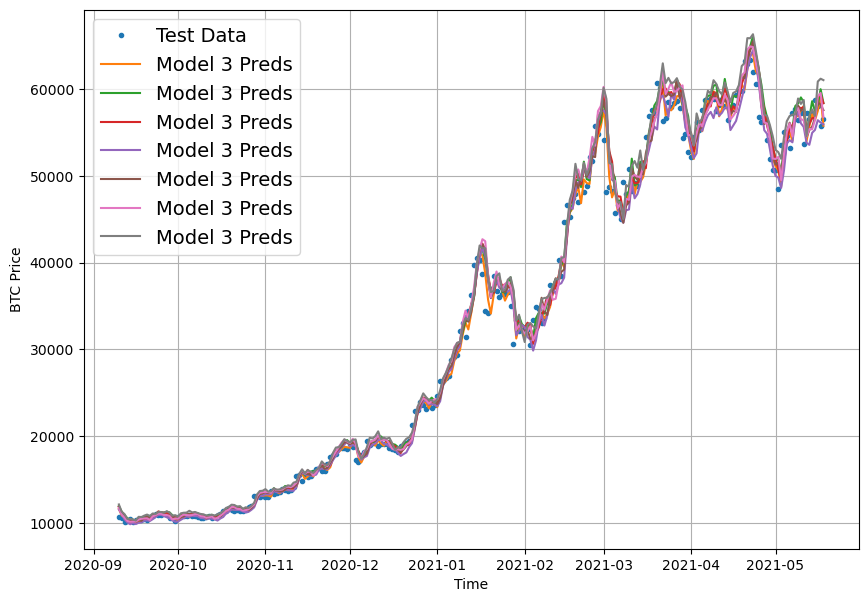

In [48]:
#031 Model 3 Visualizing the results
offset = 300

plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):],values=test_labels[:,0],start=offset,label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):],values=model_3_preds,start=offset,format='-',label="Model 3 Preds")

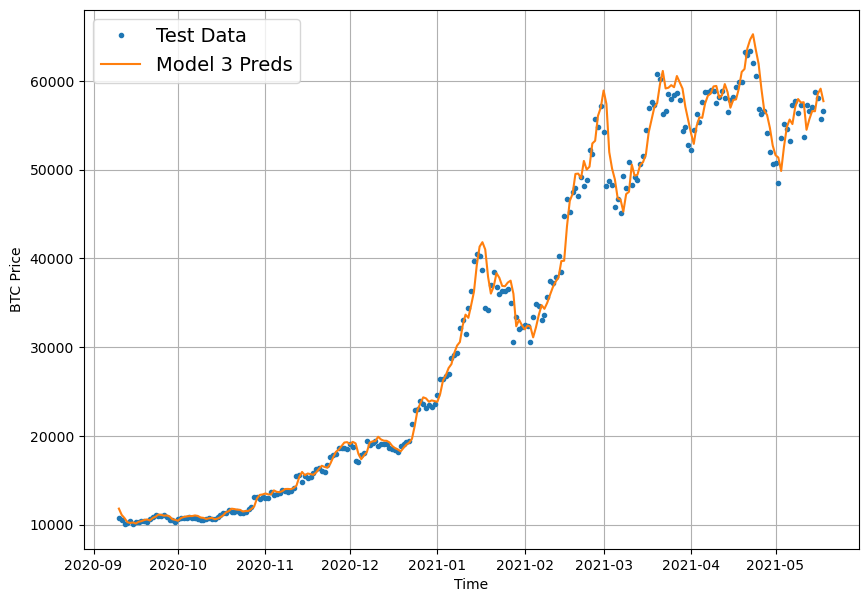

In [49]:
#031 Model 3 Visualizing the results
offset = 300

plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):],values=test_labels[:,0],start=offset,label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):],values=tf.reduce_mean(model_3_preds,axis=1),start=offset,format='-',label="Model 3 Preds")

<Axes: >

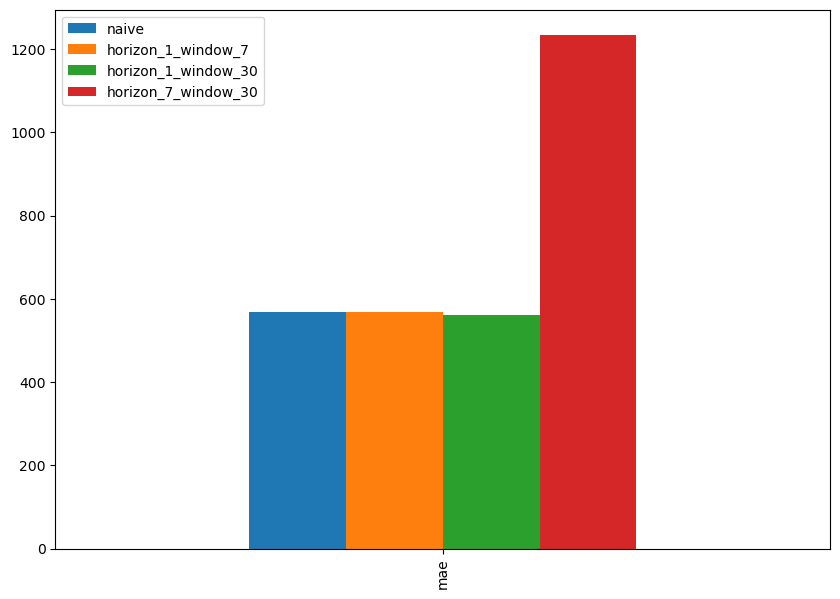

In [52]:
#032 Comparing our modelling experiments so far and discussing autocorrelation

pd.DataFrame({"naive":naive_results["mae"],
             "horizon_1_window_7":model_1_results["mae"],
             "horizon_1_window_30":model_2_results["mae"],
             "horizon_7_window_30":model_3_results["mae"],},index=['mae']).plot(figsize=(10,7),kind = "bar")


In [53]:
#033 Preparing data for building a Conv1D model
HORIZON = 1
WINDOW_SIZE = 7

full_windows,full_labels = make_windows(bitcoin_prices['Price'].to_numpy(),window_size=WINDOW_SIZE,horizon=HORIZON)
len(full_windows),len(full_labels)

(2780, 2780)

In [55]:
train_windows,test_windows,train_labels,test_labels = make_train_test_splits(full_windows,full_labels)
len(train_windows),len(train_labels),len(test_windows),len(test_labels)

(2224, 2224, 556, 556)

In [56]:
#input shape : (batch_size,timesteps,input_dim)
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x : tf.expand_dims(x,axis=1))

In [60]:
#034 Model 4 Building, fitting and evaluating a Conv1D model on our Bitcoin data
tf.random.set_seed(42)
model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x : tf.expand_dims(x,axis=1)),
    layers.Conv1D(filters=128,kernel_size=5 , strides = 1,padding = 'causal',activation = 'relu' ),
    layers.Dense(HORIZON)
],name = "model_4_conv1D")

model_4.compile(loss="mae",optimizer=tf.keras.optimizers.Adam())
model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


In [61]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d_2 (Conv1D)           (None, 1, 128)            4608      
                                                                 
 dense_7 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [62]:
model_4.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 589.6437


589.6437377929688

In [63]:
model_4 = tf.keras.models.load_model('model_experiments/model_4_conv1D')
model_4.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 578.1661


578.1661376953125

In [64]:
model_4_preds = make_preds(model_4,test_windows)
model_4_preds

18/18 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(556,), dtype=float32, numpy=
array([ 8907.862 ,  8799.139 ,  8988.801 ,  8777.538 ,  8737.094 ,
        8747.74  ,  8678.629 ,  8534.426 ,  8472.3955,  8511.752 ,
        8277.945 ,  8135.601 ,  8075.2803,  7712.445 ,  7332.98  ,
        7264.8633,  7065.9146,  7129.118 ,  7123.3423,  7415.4307,
        7423.0225,  7664.0947,  7614.314 ,  7450.485 ,  7360.0073,
        7319.9795,  7227.66  ,  7338.8623,  7475.0127,  7530.325 ,
        7560.769 ,  7406.113 ,  7277.3066,  7208.485 ,  7182.0317,
        7212.4316,  7115.696 ,  7105.242 ,  6938.6533,  6656.7773,
        7200.9214,  7193.6357,  7148.6006,  7272.0996,  7278.151 ,
        7198.0166,  7220.4453,  7222.9854,  7192.4375,  7216.8667,
        7293.4478,  7369.887 ,  7292.0537,  7209.82  ,  7183.3022,
        7008.936 ,  7200.486 ,  7311.614 ,  7347.1084,  7635.82  ,
        7984.0576,  8096.9663,  7917.1084,  8065.677 ,  8106.4795,
        8140.1797,  8129.886 ,  8599.2   ,  8832.965 ,  8779.266 ,
        8922.9

In [65]:
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),y_pred=model_4_preds)
model_4_results

{'mae': 578.1662,
 'mse': 1206514.5,
 'rmse': 1098.4146,
 'mape': 2.585871,
 'mase': 1.0156779}

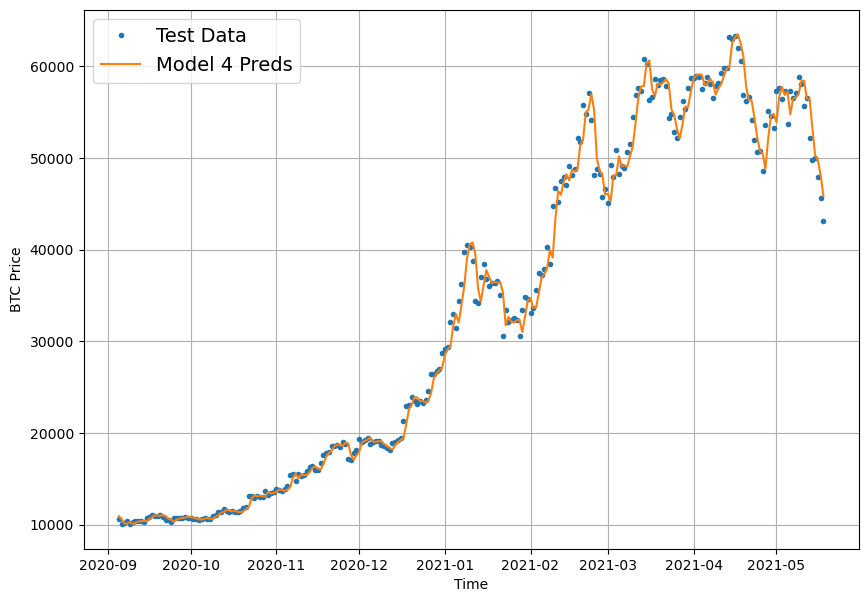

In [67]:
offset = 300

plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):],values=test_labels[:,0],start=offset,label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):],values=model_4_preds,start=offset,format='-',label="Model 4 Preds")

In [71]:
#035 Model 5 Building, fitting and evaluating a LSTM (RNN) model on our Bitcoin data
tf.random.set_seed(42)
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x : tf.expand_dims(x,axis=1))(inputs)
#x = layers.LSTM(128,return_sequences = True)(x)
x = layers.LSTM(128,activation='relu')(x)
#x = layers.Dense(32,activation = 'relu')(x)
output = layers.Dense(HORIZON)(x)

model_5 = tf.keras.Model(inputs=inputs,outputs = output,name='model_5_LSTM')

model_5.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())

model_5.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=1,
            validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/100
10/18 [===============>..............] - ETA: 0s - loss: 2315.1340 INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 79ms/step - loss: 1887.7734 - val_loss: 5593.2070
Epoch 2/100
13/18 [====================>.........] - ETA: 0s - loss: 409.7689INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 68ms/step - loss: 382.5005 - val_loss: 1769.0927
Epoch 3/100
12/18 [===================>..........] - ETA: 0s - loss: 224.4892INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 107ms/step - loss: 217.9946 - val_loss: 1244.7653
Epoch 4/100
12/18 [===================>..........] - ETA: 0s - loss: 191.3962INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 70ms/step - loss: 179.6470 - val_loss: 1025.6696
Epoch 5/100
11/18 [=================>............] - ETA: 0s - loss: 183.8029INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 70ms/step - loss: 175.0478 - val_loss: 975.5547
Epoch 6/100
12/18 [===================>..........] - ETA: 0s - loss: 169.1471INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 70ms/step - loss: 172.6989 - val_loss: 960.1529
Epoch 7/100
12/18 [===================>..........] - ETA: 0s - loss: 178.4868INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 71ms/step - loss: 173.7985 - val_loss: 952.8669
Epoch 8/100
10/18 [===============>..............] - ETA: 0s - loss: 166.7605INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 71ms/step - loss: 170.2884 - val_loss: 950.9916
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 168.9410 - val_loss: 953.1614
Epoch 10/100
11/18 [=================>............] - ETA: 0s - loss: 163.3423INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 69ms/step - loss: 167.4504 - val_loss: 937.0027
Epoch 11/100
12/18 [===================>..........] - ETA: 0s - loss: 174.8143INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 97ms/step - loss: 167.0451 - val_loss: 922.6768
Epoch 12/100
12/18 [===================>..........] - ETA: 0s - loss: 165.8070INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 69ms/step - loss: 166.4355 - val_loss: 919.5801
Epoch 13/100
18/18 [==============================] - 0s 6ms/step - loss: 164.8342 - val_loss: 1050.9663
Epoch 14/100
18/18 [==============================] - 0s 6ms/step - loss: 162.7939 - val_loss: 935.3534
Epoch 15/100
13/18 [====================>.........] - ETA: 0s - loss: 162.5010INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 69ms/step - loss: 164.1817 - val_loss: 890.8738
Epoch 16/100
12/18 [===================>..........] - ETA: 0s - loss: 157.4615INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 70ms/step - loss: 159.1317 - val_loss: 875.5082
Epoch 17/100
18/18 [==============================] - 0s 7ms/step - loss: 156.2458 - val_loss: 954.0212
Epoch 18/100
18/18 [==============================] - 0s 7ms/step - loss: 156.0857 - val_loss: 928.2589
Epoch 19/100
18/18 [==============================] - 0s 7ms/step - loss: 153.4176 - val_loss: 889.7787
Epoch 20/100
13/18 [====================>.........] - ETA: 0s - loss: 161.2267INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 69ms/step - loss: 155.6830 - val_loss: 864.9417
Epoch 21/100
12/18 [===================>..........] - ETA: 0s - loss: 153.0335INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 69ms/step - loss: 150.5302 - val_loss: 846.2028
Epoch 22/100
12/18 [===================>..........] - ETA: 0s - loss: 160.8814INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 69ms/step - loss: 149.0559 - val_loss: 837.9750
Epoch 23/100
18/18 [==============================] - 0s 6ms/step - loss: 148.2600 - val_loss: 875.2321
Epoch 24/100
13/18 [====================>.........] - ETA: 0s - loss: 143.8994INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 67ms/step - loss: 146.6274 - val_loss: 822.9288
Epoch 25/100
12/18 [===================>..........] - ETA: 0s - loss: 154.7412INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 100ms/step - loss: 148.3715 - val_loss: 820.8306
Epoch 26/100
18/18 [==============================] - 0s 6ms/step - loss: 146.8860 - val_loss: 835.9838
Epoch 27/100
13/18 [====================>.........] - ETA: 0s - loss: 147.2822INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 68ms/step - loss: 143.0825 - val_loss: 802.6904
Epoch 28/100
11/18 [=================>............] - ETA: 0s - loss: 145.4211INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 70ms/step - loss: 142.1335 - val_loss: 787.8384
Epoch 29/100
18/18 [==============================] - 0s 6ms/step - loss: 140.8587 - val_loss: 798.2058
Epoch 30/100
18/18 [==============================] - 0s 7ms/step - loss: 142.2963 - val_loss: 805.6802
Epoch 31/100
11/18 [=================>............] - ETA: 0s - loss: 139.1730INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 69ms/step - loss: 139.0639 - val_loss: 765.2736
Epoch 32/100
18/18 [==============================] - 0s 7ms/step - loss: 136.0124 - val_loss: 772.4592
Epoch 33/100
18/18 [==============================] - 0s 6ms/step - loss: 136.6892 - val_loss: 789.6715
Epoch 34/100
12/18 [===================>..........] - ETA: 0s - loss: 140.5737INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 68ms/step - loss: 135.7274 - val_loss: 739.9901
Epoch 35/100
18/18 [==============================] - 0s 7ms/step - loss: 133.0789 - val_loss: 748.5636
Epoch 36/100
12/18 [===================>..........] - ETA: 0s - loss: 133.5450INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 68ms/step - loss: 134.8399 - val_loss: 731.6169
Epoch 37/100
18/18 [==============================] - 0s 7ms/step - loss: 131.1492 - val_loss: 755.6071
Epoch 38/100
11/18 [=================>............] - ETA: 0s - loss: 139.1650INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 69ms/step - loss: 130.1180 - val_loss: 712.4409
Epoch 39/100
12/18 [===================>..........] - ETA: 0s - loss: 132.0549INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 97ms/step - loss: 130.6791 - val_loss: 704.2847
Epoch 40/100
18/18 [==============================] - 0s 7ms/step - loss: 132.1024 - val_loss: 721.8398
Epoch 41/100
11/18 [=================>............] - ETA: 0s - loss: 133.1724INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 69ms/step - loss: 126.9475 - val_loss: 694.2152
Epoch 42/100
11/18 [=================>............] - ETA: 0s - loss: 127.8881INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 70ms/step - loss: 126.2823 - val_loss: 688.0515
Epoch 43/100
18/18 [==============================] - 0s 7ms/step - loss: 125.4768 - val_loss: 691.3972
Epoch 44/100
11/18 [=================>............] - ETA: 0s - loss: 119.4276INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 69ms/step - loss: 125.0878 - val_loss: 677.2532
Epoch 45/100
11/18 [=================>............] - ETA: 0s - loss: 121.7719INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 71ms/step - loss: 122.2994 - val_loss: 671.6712
Epoch 46/100
12/18 [===================>..........] - ETA: 0s - loss: 128.3433INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 69ms/step - loss: 122.9195 - val_loss: 668.9854
Epoch 47/100
12/18 [===================>..........] - ETA: 0s - loss: 111.7803INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 70ms/step - loss: 122.0334 - val_loss: 667.0369
Epoch 48/100
18/18 [==============================] - 0s 6ms/step - loss: 120.7349 - val_loss: 686.2531
Epoch 49/100
18/18 [==============================] - 0s 6ms/step - loss: 120.8148 - val_loss: 669.8917
Epoch 50/100
18/18 [==============================] - 0s 6ms/step - loss: 123.7527 - val_loss: 696.1661
Epoch 51/100
18/18 [==============================] - 0s 7ms/step - loss: 121.7528 - val_loss: 710.1062
Epoch 52/100
12/18 [===================>..........] - ETA: 0s - loss: 126.5542INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 95ms/step - loss: 119.3032 - val_loss: 647.1921
Epoch 53/100
12/18 [===================>..........] - ETA: 0s - loss: 116.6975INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 69ms/step - loss: 119.4222 - val_loss: 640.7880
Epoch 54/100
18/18 [==============================] - 0s 7ms/step - loss: 120.5911 - val_loss: 643.2888
Epoch 55/100
12/18 [===================>..........] - ETA: 0s - loss: 123.7350INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 69ms/step - loss: 117.5385 - val_loss: 635.2466
Epoch 56/100
18/18 [==============================] - 0s 7ms/step - loss: 118.0990 - val_loss: 649.3312
Epoch 57/100
18/18 [==============================] - 0s 7ms/step - loss: 125.8626 - val_loss: 679.7320
Epoch 58/100
18/18 [==============================] - 0s 7ms/step - loss: 118.0521 - val_loss: 638.7313
Epoch 59/100
13/18 [====================>.........] - ETA: 0s - loss: 113.6720INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 70ms/step - loss: 116.4697 - val_loss: 626.5118
Epoch 60/100
18/18 [==============================] - 0s 8ms/step - loss: 115.9551 - val_loss: 633.8209
Epoch 61/100
18/18 [==============================] - 0s 8ms/step - loss: 116.6957 - val_loss: 653.7161
Epoch 62/100
18/18 [==============================] - 0s 7ms/step - loss: 118.1926 - val_loss: 671.1022
Epoch 63/100
14/18 [======================>.......] - ETA: 0s - loss: 124.9372INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 69ms/step - loss: 121.5290 - val_loss: 623.2183
Epoch 64/100
18/18 [==============================] - 0s 7ms/step - loss: 115.0845 - val_loss: 629.8077
Epoch 65/100
12/18 [===================>..........] - ETA: 0s - loss: 117.4099INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 68ms/step - loss: 116.0813 - val_loss: 622.5541
Epoch 66/100
18/18 [==============================] - 0s 7ms/step - loss: 114.6351 - val_loss: 629.9423
Epoch 67/100
12/18 [===================>..........] - ETA: 0s - loss: 112.3560INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 93ms/step - loss: 115.9857 - val_loss: 614.8600
Epoch 68/100
18/18 [==============================] - 0s 7ms/step - loss: 116.4696 - val_loss: 615.0265
Epoch 69/100
18/18 [==============================] - 0s 7ms/step - loss: 120.2310 - val_loss: 635.7787
Epoch 70/100
11/18 [=================>............] - ETA: 0s - loss: 113.1087INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 69ms/step - loss: 114.7672 - val_loss: 610.4572
Epoch 71/100
18/18 [==============================] - 0s 7ms/step - loss: 114.9572 - val_loss: 639.1658
Epoch 72/100
12/18 [===================>..........] - ETA: 0s - loss: 115.9793INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 69ms/step - loss: 117.6599 - val_loss: 608.8622
Epoch 73/100
18/18 [==============================] - 0s 6ms/step - loss: 114.1215 - val_loss: 615.3237
Epoch 74/100
18/18 [==============================] - 0s 7ms/step - loss: 114.1503 - val_loss: 614.8218
Epoch 75/100
18/18 [==============================] - 0s 7ms/step - loss: 114.0900 - val_loss: 632.1227
Epoch 76/100
18/18 [==============================] - 0s 7ms/step - loss: 114.6855 - val_loss: 612.3668
Epoch 77/100
18/18 [==============================] - 0s 6ms/step - loss: 115.6169 - val_loss: 674.7471
Epoch 78/100
18/18 [==============================] - 0s 6ms/step - loss: 117.3253 - val_loss: 629.6488
Epoch 79/100
11/18 [=================>............] - ETA: 0s - loss: 110.6071INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 69ms/step - loss: 114.3152 - val_loss: 602.6248
Epoch 80/100
18/18 [==============================] - 0s 7ms/step - loss: 112.8380 - val_loss: 610.9990
Epoch 81/100
18/18 [==============================] - 0s 6ms/step - loss: 113.9942 - val_loss: 636.5915
Epoch 82/100
12/18 [===================>..........] - ETA: 0s - loss: 119.8328INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 69ms/step - loss: 116.2557 - val_loss: 599.7670
Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 113.4770 - val_loss: 619.9445
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 114.6165 - val_loss: 604.2420
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 112.7168 - val_loss: 626.2141
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 114.9993 - val_loss: 627.2950
Epoch 87/100
11/18 [=================>............] - ETA: 0s - loss: 119.3905INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 71ms/step - loss: 114.3427 - val_loss: 596.6235
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 112.7315 - val_loss: 607.2104
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 112.6042 - val_loss: 653.4058
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 121.2456 - val_loss: 627.2961
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 118.1722 - val_loss: 669.2874
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 114.1682 - val_loss: 617.3135
Epoch 93/100
18/18 [==============================] - 0s 6ms/step - loss: 112.7618 - val_loss: 601.0178
Epoch 94/100
18/18 [==============================] - 0s 7ms/step - loss: 113.1358 - val_loss: 629.2224
Epoch 95/100
18/18 [==============================] - 0s 7ms/step - loss: 113.0520 - val_loss: 608.9900
Epoch 96/100
18/18 [==============================] - 0s 7ms/step - loss: 11

INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 69ms/step - loss: 113.2403 - val_loss: 590.7582
Epoch 99/100
13/18 [====================>.........] - ETA: 0s - loss: 107.5728INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 1s 70ms/step - loss: 111.3109 - val_loss: 589.9353
Epoch 100/100
18/18 [==============================] - 0s 7ms/step - loss: 113.4377 - val_loss: 599.2943


In [72]:
model_5 = tf.keras.models.load_model('model_experiments/model_5_LSTM')
model_5.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 590.1335


590.133544921875

In [73]:
model_5_preds = make_preds(model_5,test_windows)
model_5_preds[:5]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([8943.068 , 8785.837 , 8952.654 , 8814.784 , 8752.1045],
      dtype=float32)>

In [74]:
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                y_pred=model_5_preds)
model_5_results

{'mae': 590.1335,
 'mse': 1243782.2,
 'rmse': 1115.2499,
 'mape': 2.649543,
 'mase': 1.0367011}

In [ ]:
#036 Investigating how to turn our univariate time series into multivariate